In [0]:
from keras.models import Model, load_model
from keras import backend as K
from keras.callbacks import ModelCheckpoint

from keras.layers import Input, concatenate, Conv2D, MaxPooling2D 
from keras.layers import UpSampling2D, Convolution2D, ZeroPadding2D
from keras.optimizers import Adam
from keras.layers import Input, Conv2D, MaxPooling2D, concatenate, UpSampling2D, BatchNormalization, Add
from keras.layers.core import Activation


import numpy as np
from numpy import genfromtxt
from numpy.testing import assert_allclose
from scipy import misc
import matplotlib.pyplot as plt

import os
from skimage.transform import resize
from skimage.io import imsave
from PIL import Image

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.0)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def Conv2D_34skipblock(filters, strides=(3, 3), activation="relu", padding="same"):
    assert(isinstance(strides, tuple))
    assert(2 == len(strides))

    def f(x):
        conv1 = Conv2D(filters, strides, padding=padding)(x)
        batch_norm1 = BatchNormalization()(conv1)
        act1 = Activation(activation=activation)(batch_norm1)
        conv2 = Conv2D(filters, strides, padding=padding)(act1)
        batch_norm2 = BatchNormalization()(conv2)
        act2 = Activation(activation=activation)(batch_norm2)
        add = Add()([x, act2])
        return add
    return f

def uresnet(skip_block, image_rows, image_cols, img_channels=1):

    inputs = Input((image_rows, image_cols, img_channels))
    conv0 = Conv2D(32, (3, 3), padding='same')(inputs)
    batch_norm0 = BatchNormalization()(conv0)
    act0 = Activation(activation='relu')(batch_norm0)

    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(act0)
    conv1 = skip_block(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = skip_block(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = skip_block(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = skip_block(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = skip_block(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = skip_block(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = skip_block(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = skip_block(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = skip_block(512, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = skip_block(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = skip_block(256, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = skip_block(256, (3, 3), activation='relu', padding='same')(conv6)
    
    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = skip_block(128, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = skip_block(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = skip_block(64, (3, 3), activation='relu', padding='same')(conv8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)
    conv8 = skip_block(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = skip_block(32, (3, 3), activation='relu', padding='same')(conv9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)
    conv9 = skip_block(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])
        
    model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, metrics=[dice_coef])

    return model

Using TensorFlow backend.


In [0]:
K.set_image_data_format('channels_last')

NB_EPOCH = 40
BATCH_SIZE = 10
VERBOSE = 1
VALIDATION_SPLIT = 0.2
OPTIMIZER = Adam()
IMG_ROWS, IMG_COLS, IMG_CHANNELS = 320, 240, 1
INPUT_SHAPE = (IMG_ROWS, IMG_COLS, IMG_CHANNELS)

Train = 1314
Valid = 145

x_train = []
y_train = []

x_valid = []
y_valid = []

from google.colab import drive
drive.mount('/content/drive')

path = os.getcwd()+'people\\'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
print('__________LOAD TRAIN DATA__________')
for i in range(1315):
  x_train.append((np.array(Image.open('/content/drive/My Drive/Colab Notebooks/people/train/'+str(i)+'.jpg'))).dot([0.299, 0.587, 0.114]))
  y_train.append(np.array(Image.open('/content/drive/My Drive/Colab Notebooks/people/train_mask/'+str(i)+'.png'))) 
  if i%130==0: print(i//13,' %')
print('__________END LOAD TRAIN DATA__________') 

print('__________LOAD VALID DATA__________')
for i in range(145):
  x_valid.append((np.array(Image.open('/content/drive/My Drive/Colab Notebooks/people/valid/'+str(1315+i)+'.jpg'))).dot([0.299, 0.587, 0.114]))
  y_valid.append(np.array(Image.open('/content/drive/My Drive/Colab Notebooks/people/valid_mask/'+str(1315+i)+'.png')))
print('\n__________END LOAD VALID DATA__________')

print('__________STAR PREPROCCECING__________')

x_train = np.array(x_train)
x_train = x_train.astype('float32')
x_train -= x_train.mean()
x_train /= x_train.std()
x_train = x_train[:, :, :, np.newaxis]


y_train = np.array(y_train)
y_train = y_train.astype('float32')
y_train /= 255
y_train = y_train[:, :, :, np.newaxis]


x_valid = np.array(x_valid)
x_valid = x_valid.astype('float32')
x_valid -= x_valid.mean()
x_valid /= x_valid.std()
x_valid = x_valid[:, :, :, np.newaxis]


y_valid = np.array(y_valid)
y_valid = y_valid.astype('float32')
y_valid /= 255
y_valid = y_valid[:, :, :, np.newaxis]
print('__________END PREPROCCECING__________')

__________LOAD TRAIN DATA__________
0  %
10  %
20  %
30  %
40  %
50  %
60  %
70  %
80  %
90  %
100  %
__________END LOAD TRAIN DATA__________
__________LOAD VALID DATA__________

__________END LOAD VALID DATA__________
__________STAR PREPROCCECING__________
__________END PREPROCCECING__________


Train on 1052 samples, validate on 263 samples
Epoch 1/40
1052/1052 [==============================] - 198s 188ms/step - loss: -0.7199 - dice_coef: 0.7199 - val_loss: -0.8079 - val_dice_coef: 0.8079
Epoch 2/40
1052/1052 [==============================] - 186s 177ms/step - loss: -0.8518 - dice_coef: 0.8518 - val_loss: -0.8260 - val_dice_coef: 0.8260
Epoch 3/40
1052/1052 [==============================] - 186s 177ms/step - loss: -0.8707 - dice_coef: 0.8707 - val_loss: -0.8653 - val_dice_coef: 0.8653
Epoch 4/40
1052/1052 [==============================] - 186s 177ms/step - loss: -0.8775 - dice_coef: 0.8775 - val_loss: -0.8916 - val_dice_coef: 0.8916
Epoch 5/40
1052/1052 [==============================] - 186s 177ms/step - loss: -0.8872 - dice_coef: 0.8872 - val_loss: -0.8909 - val_dice_coef: 0.8909
Epoch 6/40
1052/1052 [==============================] - 186s 177ms/step - loss: -0.8935 - dice_coef: 0.8935 - val_loss: -0.8797 - val_dice_coef: 0.8797
Epoch 7/40
1052/1052 [===================

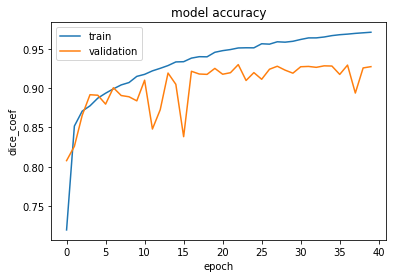

In [0]:
model = uresnet(Conv2D_34skipblock, IMG_ROWS, IMG_COLS, IMG_CHANNELS)

model_checkpoint = ModelCheckpoint('foto_weights.h5', monitor='val_loss', save_best_only=True)
history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=NB_EPOCH, verbose=VERBOSE, 
                    shuffle=True, validation_split=VALIDATION_SPLIT, callbacks=[model_checkpoint])

score = model.evaluate(x_valid, y_valid, batch_size=BATCH_SIZE, verbose=VERBOSE)

plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.title('model accuracy')
plt.ylabel('dice_coef')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc = 'upper left')
plt.show()